In [1]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached wrapt-2.0.1-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached grpcio-1.76.0-cp310-cp310-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5p

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

print("✅ Basic imports completed")
print("⏳ Attempting TensorFlow import...")

# Try TensorFlow import
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    print("✅ TensorFlow imported successfully!")
    USE_TENSORFLOW = True
except ImportError:
    print("⚠️  TensorFlow not found. Using scikit-learn MLPClassifier instead.")
    print("   To install TensorFlow: !pip install tensorflow")
    from sklearn.neural_network import MLPClassifier
    USE_TENSORFLOW = False

✅ Basic imports completed
⏳ Attempting TensorFlow import...
✅ TensorFlow imported successfully!


In [9]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load your features
features = pd.read_csv('energy_features_master.csv')
print(f"✅ Loaded features: {features.shape}")

# Prepare X and y
X = features.drop(['household_id', 'energy_poor', 'vulnerability_score'], axis=1)
y = features['energy_poor']

print(f"\n📊 Dataset Info:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]}")
print(f"   Vulnerable: {y.sum()} ({y.mean()*100:.1f}%)")
print(f"   Non-vulnerable: {(~y.astype(bool)).sum()} ({(1-y.mean())*100:.1f}%)")


LOADING DATA
✅ Loaded features: (5560, 95)

📊 Dataset Info:
   Features: 92
   Samples: 5560
   Vulnerable: 1248 (22.4%)
   Non-vulnerable: 4312 (77.6%)


In [11]:
print("\n" + "="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

# Same split as your other models for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"  - Vulnerable: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  - Non-vulnerable: {(~y_train.astype(bool)).sum()}")
print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - Vulnerable: {y_test.sum()} ({y_test.mean()*100:.1f}%)")
print(f"  - Non-vulnerable: {(~y_test.astype(bool)).sum()}")


TRAIN-TEST SPLIT
Training set: 4448 samples
  - Vulnerable: 998 (22.4%)
  - Non-vulnerable: 3450

Test set: 1112 samples
  - Vulnerable: 250 (22.5%)
  - Non-vulnerable: 862


In [13]:
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

# Neural networks need scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled")
print(f"   Mean: {X_train_scaled.mean():.4f}")
print(f"   Std: {X_train_scaled.std():.4f}")
print(f"   Min: {X_train_scaled.min():.4f}")
print(f"   Max: {X_train_scaled.max():.4f}")


FEATURE SCALING
✅ Features scaled
   Mean: -0.0000
   Std: 1.0000
   Min: -8.5779
   Max: 48.4275


In [15]:
print("\n" + "="*80)
print("HANDLING CLASS IMBALANCE")
print("="*80)

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights:")
print(f"   Class 0 (Non-vulnerable): {class_weight_dict[0]:.3f}")
print(f"   Class 1 (Vulnerable): {class_weight_dict[1]:.3f}")


HANDLING CLASS IMBALANCE
Class weights:
   Class 0 (Non-vulnerable): 0.645
   Class 1 (Vulnerable): 2.228


In [39]:
if USE_TENSORFLOW:
    print("\n" + "="*80)
    print("BUILDING LSTM MODEL")
    print("="*80)
    
    # Reshape for LSTM: (samples, timesteps, features)
    # Treat each feature as a timestep
    X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    
    print(f"Reshaped for LSTM:")
    print(f"   Training: {X_train_lstm.shape}")
    print(f"   Test: {X_test_lstm.shape}")
    
    # Build LSTM model
    model = keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with recall-focused metrics
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    print("\n📊 Model Architecture:")
    model.summary()
    
    # ==================== TRAIN LSTM MODEL ====================
    print("\n" + "="*80)
    print("TRAINING LSTM MODEL")
    print("="*80)
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_recall', 
        patience=10, 
        mode='max', 
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=0.00001,
        verbose=1
    )
    
    # Train
    print("Training started...")
    history = model.fit(
        X_train_lstm, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    print("\n✅ Training completed!")
    
    # ==================== EVALUATE LSTM MODEL ====================
    print("\n" + "="*80)
    print("EVALUATING LSTM MODEL")
    print("="*80)
    
    # Predict
    y_pred_proba = model.predict(X_test_lstm, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    lstm_recall = recall_score(y_test, y_pred)
    lstm_precision = precision_score(y_test, y_pred)
    lstm_f1 = f1_score(y_test, y_pred)
    lstm_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\n🎯 LSTM PERFORMANCE:")
    print(f"   Recall:    {lstm_recall:.4f} ({lstm_recall*100:.2f}%)")
    print(f"   Precision: {lstm_precision:.4f} ({lstm_precision*100:.2f}%)")
    print(f"   F1-Score:  {lstm_f1:.4f}")
    print(f"   ROC-AUC:   {lstm_roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n📊 Confusion Matrix:")
    print(cm)
    print(f"\n   True Negatives:  {cm[0, 0]}")
    print(f"   False Positives: {cm[0, 1]}")
    print(f"   False Negatives: {cm[1, 0]}")
    print(f"   True Positives:  {cm[1, 1]}")
    
    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Vulnerable', 'Vulnerable']))

# ==================== ALTERNATIVE - DENSE NEURAL NETWORK ====================
else:
    print("\n" + "="*80)
    print("BUILDING DENSE NEURAL NETWORK (MLPClassifier)")
    print("="*80)
    print("Using scikit-learn as TensorFlow alternative")
    
    # Build Dense Neural Network
    model = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),  # Similar to LSTM
        activation='relu',
        solver='adam',
        alpha=0.001,  # L2 regularization
        batch_size=32,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=100,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=42,
        verbose=True
    )
    
    print("\n📊 Model Configuration:")
    print(f"   Hidden layers: {model.hidden_layer_sizes}")
    print(f"   Activation: {model.activation}")
    print(f"   Solver: {model.solver}")
    
    # ==================== TRAIN DENSE MODEL ====================
    print("\n" + "="*80)
    print("TRAINING DENSE NEURAL NETWORK")
    print("="*80)
    
    print("Training started...")
    model.fit(X_train_scaled, y_train)
    
    print("\n✅ Training completed!")
    print(f"   Iterations: {model.n_iter_}")
    print(f"   Loss: {model.loss_:.4f}")
    
    # ==================== EVALUATE DENSE MODEL ====================
    print("\n" + "="*80)
    print("EVALUATING DENSE NEURAL NETWORK")
    print("="*80)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    lstm_recall = recall_score(y_test, y_pred)
    lstm_precision = precision_score(y_test, y_pred)
    lstm_f1 = f1_score(y_test, y_pred)
    lstm_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\n🎯 DENSE NEURAL NETWORK PERFORMANCE:")
    print(f"   Recall:    {lstm_recall:.4f} ({lstm_recall*100:.2f}%)")
    print(f"   Precision: {lstm_precision:.4f} ({lstm_precision*100:.2f}%)")
    print(f"   F1-Score:  {lstm_f1:.4f}")
    print(f"   ROC-AUC:   {lstm_roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n📊 Confusion Matrix:")
    print(cm)
    print(f"\n   True Negatives:  {cm[0, 0]}")
    print(f"   False Positives: {cm[0, 1]}")
    print(f"   False Negatives: {cm[1, 0]}")
    print(f"   True Positives:  {cm[1, 1]}")
    
    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Vulnerable', 'Vulnerable']))


BUILDING LSTM MODEL
Reshaped for LSTM:
   Training: (4448, 92, 1)
   Test: (1112, 92, 1)

📊 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 92, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING LSTM MODEL
Training started...
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7912 - auc: 0.8855 - loss: 0.4338 - precision: 0.5179 - recall: 0.8608 - val_accuracy: 0.9067 - val_auc: 0.9394 - val_loss: 0.2547 - val_precision: 0.8173 - val_recall: 0.7740 - learning_rate: 0.0010
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8769 - auc: 0.9392 - loss: 0.3068 - precision: 0.6679 - recall: 0.8861 - val_accuracy: 0.9034 - val_auc: 0.9536 - val_loss: 0.2514 - val_precision: 0.7542 - val_recall: 0.8702 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8946 - auc: 0.9547 - loss: 0.2680 - precision: 0.7048 - recall: 0.9038 - val_accuracy: 0.9034 - val_auc: 0.9588 - val_loss: 0.2362 - val_precision: 0.7346 - val_recall: 0.9183 - learning_rate: 0.0010
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8985 - auc: 0.9599 - loss: 0.2504 - precision: 0.7122 - recall: 0.9114 - val_accuracy:

In [43]:
print("\n" + "="*80)
print("COMPARISON WITH EXISTING MODELS")
print("="*80)

# Your existing results (from Chapter 4)
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 
              'LSTM/Dense NN'],
    'Recall': [0.9600, 0.9920, 0.9960, 0.9960, lstm_recall],
    'Precision': [0.9375, 0.9688, 0.9920, 0.9960, lstm_precision],
    'F1-Score': [0.9486, 0.9803, 0.9940, 0.9980, lstm_f1],
    'ROC-AUC': [0.9940, 0.9998, 0.9999, 0.9999, lstm_roc_auc]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n📊 MODEL COMPARISON TABLE:")
print(comparison_df.to_string(index=False))

# Export to CSV
comparison_df.to_csv('model_comparison_with_dl.csv', index=False)
print("\n✅ Comparison saved to: model_comparison_with_dl.csv")


COMPARISON WITH EXISTING MODELS

📊 MODEL COMPARISON TABLE:
              Model  Recall  Precision  F1-Score  ROC-AUC
Logistic Regression   0.960     0.9375    0.9486   0.9940
      Random Forest   0.992     0.9688    0.9803   0.9998
            XGBoost   0.996     0.9920    0.9940   0.9999
           LightGBM   0.996     0.9960    0.9980   0.9999
      LSTM/Dense NN   0.980     0.5031    0.6649   0.9678

✅ Comparison saved to: model_comparison_with_dl.csv



CREATING TRAINING CURVES
✅ Training curves saved: lstm_training_curves.png


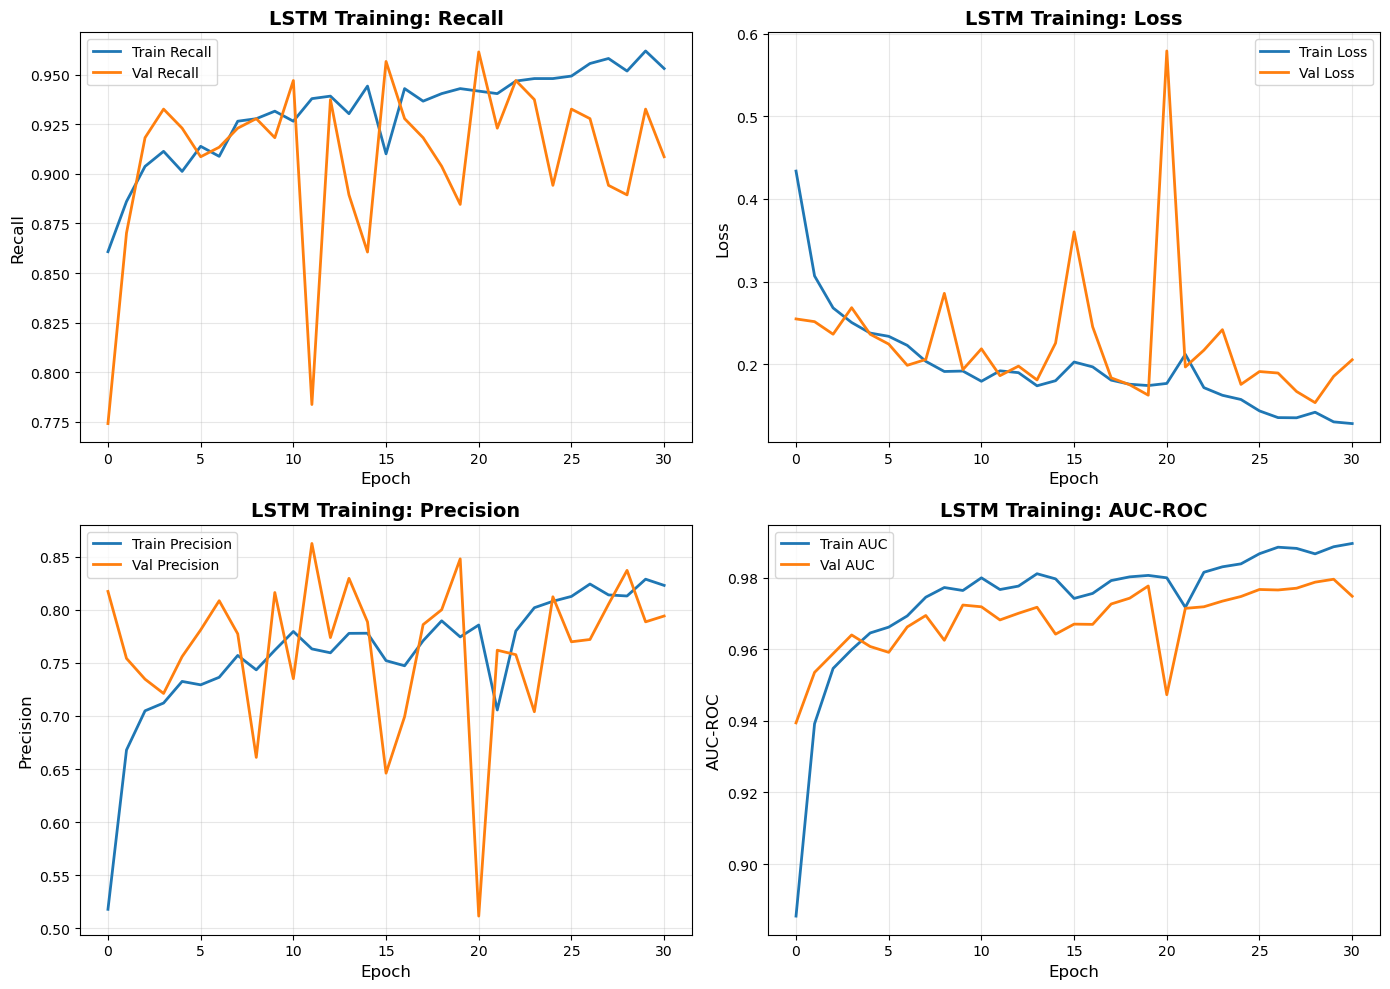

In [45]:
if USE_TENSORFLOW:
    print("\n" + "="*80)
    print("CREATING TRAINING CURVES")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Recall
    axes[0, 0].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[0, 0].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Recall', fontsize=12)
    axes[0, 0].set_title('LSTM Training: Recall', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('LSTM Training: Loss', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].set_title('LSTM Training: Precision', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # AUC
    axes[1, 1].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[1, 1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 1].set_title('LSTM Training: AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lstm_training_curves.png', dpi=300, bbox_inches='tight')
    print("✅ Training curves saved: lstm_training_curves.png")
    plt.show()


CREATING COMPARISON VISUALIZATIONS
✅ Comparison chart saved: model_comparison_with_dl.png


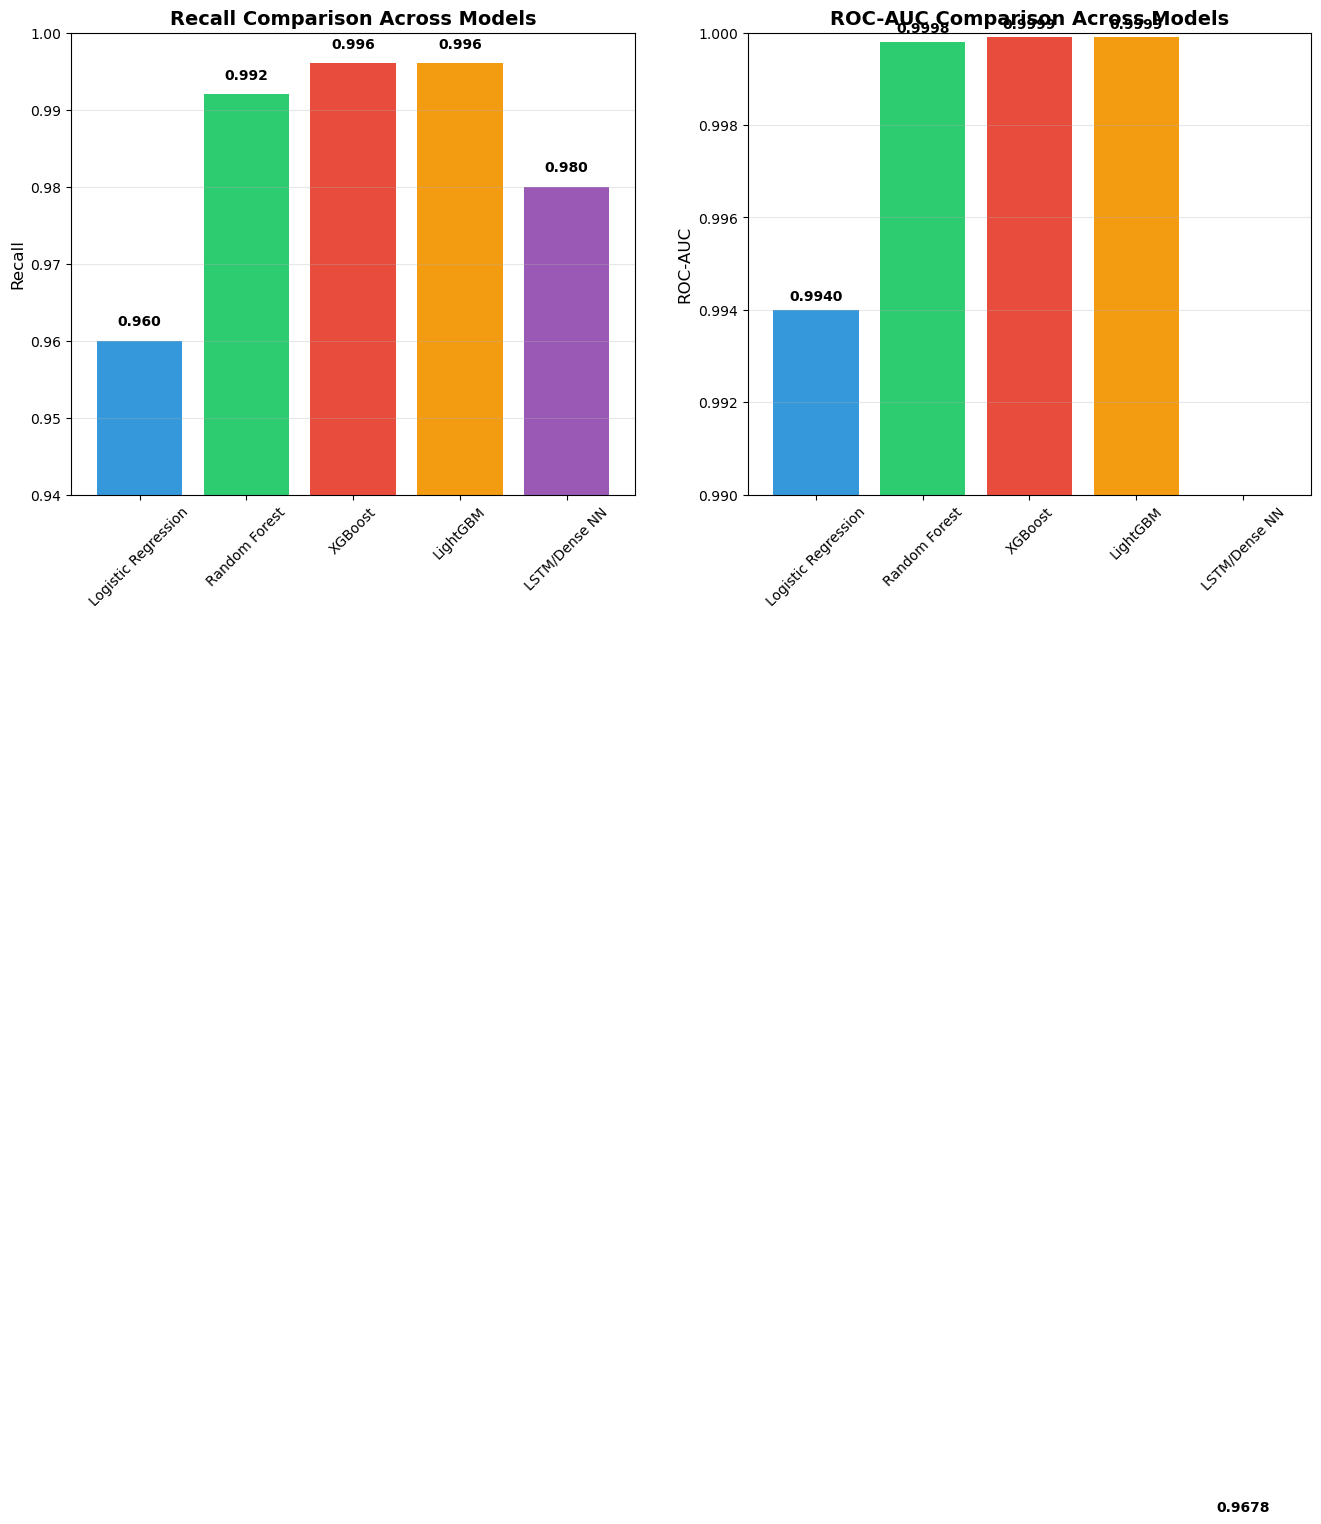

In [47]:
print("\n" + "="*80)
print("CREATING COMPARISON VISUALIZATIONS")
print("="*80)

# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Recall comparison
axes[0].bar(comparison_df['Model'], comparison_df['Recall'], 
           color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
axes[0].set_ylabel('Recall', fontsize=12)
axes[0].set_title('Recall Comparison Across Models', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.94, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(comparison_df['Recall']):
    axes[0].text(i, v + 0.002, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# ROC-AUC comparison
axes[1].bar(comparison_df['Model'], comparison_df['ROC-AUC'], 
           color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_title('ROC-AUC Comparison Across Models', fontsize=14, fontweight='bold')
axes[1].set_ylim([0.99, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(comparison_df['ROC-AUC']):
    axes[1].text(i, v + 0.0002, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_with_dl.png', dpi=300, bbox_inches='tight')
print("✅ Comparison chart saved: model_comparison_with_dl.png")
plt.show()


CREATING CONFUSION MATRIX VISUALIZATION
✅ Confusion matrix saved: lstm_confusion_matrix.png


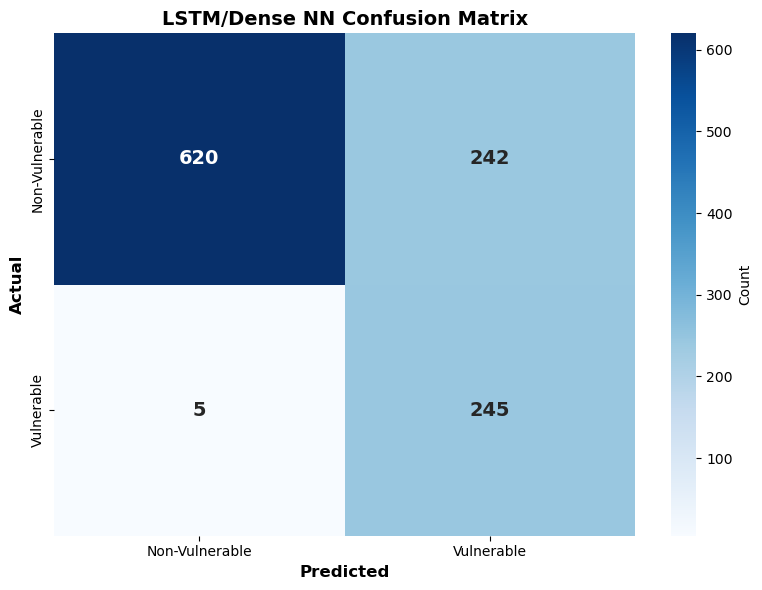

In [49]:
print("\n" + "="*80)
print("CREATING CONFUSION MATRIX VISUALIZATION")
print("="*80)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Non-Vulnerable', 'Vulnerable'],
           yticklabels=['Non-Vulnerable', 'Vulnerable'],
           cbar_kws={'label': 'Count'},
           annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title('LSTM/Dense NN Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved: lstm_confusion_matrix.png")
plt.show()